<a href="https://colab.research.google.com/github/jiiinchoi/machine-learning/blob/main/Nucleiseg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"jiinchoiii","key":"593dcbc01e049c2cadd7a35210df2076"}'}

In [18]:
# 0) Kaggle CLI 설치
!pip -q install kaggle

# 1) kaggle.json 업로드 (파일 선택창에서 kaggle.json 선택)
from google.colab import files, output
import os, json, zipfile

if not os.path.exists('/root/.kaggle/kaggle.json'):
    uploaded = files.upload()  # 여기서 kaggle.json 업로드
    # 혹시 파일명이 'kaggle (1).json' 같이 올라오면 강제로 이름 맞추기
    upname = [k for k in uploaded.keys()][0]
    os.makedirs('/root/.kaggle', exist_ok=True)
    os.rename(upname, 'kaggle.json')
    !cp kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

# (선택) 환경변수도 세팅 — 같은 셀에서 !kaggle 명령이 바로 먹도록
with open('/root/.kaggle/kaggle.json') as f:
    token = json.load(f)
os.environ['KAGGLE_USERNAME'] = token['username']
os.environ['KAGGLE_KEY'] = token['key']

# 2) 데이터셋 다운로드 (이미 있으면 덮어쓰기 -o)
!kaggle datasets download -d espsiyam/nuclei-image-segmentation -p /content -o

# 3) 압축 해제
zip_path = "/content/nuclei-image-segmentation.zip"
extract_dir = "/content/nuclei-data"
os.makedirs(extract_dir, exist_ok=True)

assert os.path.exists(zip_path), "다운로드가 실패했습니다. 위의 kaggle 출력 로그를 확인하세요."
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

print("압축 해제 완료! 최상위 폴더:", os.listdir(extract_dir))

# 4) 구조 확인
for root, dirs, files in os.walk(extract_dir):
    print(root, "->", "dirs:", len(dirs), "files:", len(files))
    break


Saving kaggle (1).json to kaggle (1) (1).json
Dataset URL: https://www.kaggle.com/datasets/espsiyam/nuclei-image-segmentation
License(s): CC0-1.0
  0% 0.00/89.4M [00:00<?, ?B/s]
100% 89.4M/89.4M [00:00<00:00, 1.36GB/s]
압축 해제 완료! 최상위 폴더: ['U_NET']
/content/nuclei-data -> dirs: 1 files: 0


In [19]:
!kaggle datasets download -d espsiyam/nuclei-image-segmentation -p /content

Dataset URL: https://www.kaggle.com/datasets/espsiyam/nuclei-image-segmentation
License(s): CC0-1.0
nuclei-image-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
for root, dirs, files in os.walk(extract_dir):
    print(root, len(files))
    break


In [20]:
import os

base_path = "/content/nuclei-data/U_NET"
print("하위 폴더:", os.listdir(base_path))

print("train 샘플:", os.listdir(os.path.join(base_path, "train"))[:5])
print("test 샘플:", os.listdir(os.path.join(base_path, "test"))[:5])


하위 폴더: ['test', 'train']
train 샘플: ['3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9', '2c840a94d216f5ef4e499b53ae885e9b022cbf639e004ec788436093837823b2', 'f6b16c885c0b2bc0d0eb2bb2eeb0a2753ebafb5a7a91da10e89b0b0478984637', 'b67a6e5da8b1cfa5319d94a7d3f8b706725753346c37a4636bf7382e98b3c5df', '602f267432e7a573e1092f1cf48135c82d0fbc8722bc028b9330ec801a40bb18']
test 샘플: ['f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb', 'd616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d', '38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f', '336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523', '699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68']


In [21]:
import os, glob, cv2, numpy as np, tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120

BASE = "/content/nuclei-data/U_NET"
TRAIN_DIR = os.path.join(BASE, "train")
TEST_DIR  = os.path.join(BASE, "test")
IMG_SIZE = 256


In [22]:
def load_case(case_dir, img_size=256):
    # 이미지 1장
    img_path = sorted(glob.glob(os.path.join(case_dir, "images", "*")))[0]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 여러 장 마스크 OR로 합치기 → 0/1
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for mp in glob.glob(os.path.join(case_dir, "masks", "*")):
        m = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
        if m is not None:
            mask = np.maximum(mask, (m > 127).astype(np.uint8))

    # 리사이즈 + 정규화
    img  = cv2.resize(img,  (img_size, img_size)).astype(np.float32) / 255.0
    mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST).astype(np.float32)
    mask = mask[..., None]  # (H,W,1)
    return img, mask

def list_cases(root):
    return [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]


In [23]:
cases = list_cases(TRAIN_DIR)
train_ids, val_ids = train_test_split(cases, test_size=0.2, random_state=42, shuffle=True)

def gen(cases):
    for c in cases:
        yield load_case(c, IMG_SIZE)

train_ds = tf.data.Dataset.from_generator(lambda: gen(train_ids),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE,IMG_SIZE,3), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_SIZE,IMG_SIZE,1), dtype=tf.float32)
    )).shuffle(512).batch(8).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(lambda: gen(val_ids),
    output_signature=(
        tf.TensorSpec(shape=(IMG_SIZE,IMG_SIZE,3), dtype=tf.float32),
        tf.TensorSpec(shape=(IMG_SIZE,IMG_SIZE,1), dtype=tf.float32)
    )).batch(8).prefetch(tf.data.AUTOTUNE)

len(train_ids), len(val_ids)


(535, 134)

In [24]:
from tensorflow.keras import layers, models, backend as K
import tensorflow as tf

def conv_blk(x, f):
    x = layers.Conv2D(f, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(f, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    return x

def build_unet(img_size=256, base=64):
    inp = layers.Input((img_size, img_size, 3))
    c1 = conv_blk(inp, base);     p1 = layers.MaxPool2D(2)(c1)
    c2 = conv_blk(p1, base*2);    p2 = layers.MaxPool2D(2)(c2)
    c3 = conv_blk(p2, base*4);    p3 = layers.MaxPool2D(2)(c3)
    c4 = conv_blk(p3, base*8);    p4 = layers.MaxPool2D(2)(c4)
    bn = conv_blk(p4, base*16)

    u4 = layers.Conv2DTranspose(base*8, 2, strides=2, padding='same')(bn)
    u4 = layers.Concatenate()([u4, c4]); d4 = conv_blk(u4, base*8)
    u3 = layers.Conv2DTranspose(base*4, 2, strides=2, padding='same')(d4)
    u3 = layers.Concatenate()([u3, c3]); d3 = conv_blk(u3, base*4)
    u2 = layers.Conv2DTranspose(base*2, 2, strides=2, padding='same')(d3)
    u2 = layers.Concatenate()([u2, c2]); d2 = conv_blk(u2, base*2)
    u1 = layers.Conv2DTranspose(base,   2, strides=2, padding='same')(d2)
    u1 = layers.Concatenate()([u1, c1]); d1 = conv_blk(u1, base)

    out = layers.Conv2D(1, 1, activation='sigmoid')(d1)
    return models.Model(inp, out)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true); y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2.*inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_soft(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true); y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

def bce_dice(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1.0 - dice_coef(y_true, y_pred))

model = build_unet(IMG_SIZE, base=64)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=bce_dice, metrics=[dice_coef, iou_soft, 'accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [25]:
ckpt = tf.keras.callbacks.ModelCheckpoint(
    'unet_nuclei.keras', monitor='val_iou_soft', mode='max', save_best_only=True, verbose=1)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_iou_soft', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[ckpt, plateau])


Epoch 1/20
     67/Unknown 161s 1s/step - accuracy: 0.8611 - dice_coef: 0.4770 - iou_soft: 0.3252 - loss: 0.9012   

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_iou_soft improved from -inf to 0.11772, saving model to unet_nuclei.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.8616 - dice_coef: 0.4780 - iou_soft: 0.3261 - loss: 0.8990 - val_accuracy: 0.1182 - val_dice_coef: 0.2090 - val_iou_soft: 0.1177 - val_loss: 121.7854 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9333 - dice_coef: 0.6863 - iou_soft: 0.5290 - loss: 0.5132
Epoch 2: val_iou_soft did not improve from 0.11772
67/67 ━━━━━━━━━━━━━━━━━━━━ 78s 521ms/step - accuracy: 0.9334 - dice_coef: 0.6866 - iou_soft: 0.5295 - loss: 0.5125 - val_accuracy: 0.6804 - val_dice_coef: 0.1728 - val_iou_soft: 0.0954 - val_loss: 1.9015 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9468 - dice_coef: 0.7477 - iou_soft: 0.6044 - loss: 0.4147
Epoch 3: val_iou_soft did not improve from 0.11772
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 528ms/step - accuracy: 0.9468 - dice_coef: 0.7481 - iou_soft: 0.6049 - lo

In [26]:
import numpy as np

best = tf.keras.models.load_model('unet_nuclei.keras',
    custom_objects={'dice_coef': dice_coef, 'iou_soft': iou_soft, 'bce_dice': bce_dice})

def iou_hard(y_true, y_prob, thr=0.5, eps=1e-6):
    y_pred = (y_prob >= thr).astype(np.float32)
    inter = np.sum((y_true==1) & (y_pred==1))
    union = np.sum((y_true==1) | (y_pred==1))
    return (inter + eps) / (union + eps)

ious = []
for imgs, masks in val_ds:
    probs = best.predict(imgs, verbose=0)
    for gt, pr in zip(masks.numpy(), probs):
        ious.append(iou_hard(gt[...,0], pr[...,0], thr=0.5))
print(f"mIoU(thr=0.5): {np.mean(ious):.4f}")


mIoU(thr=0.5): 0.8149


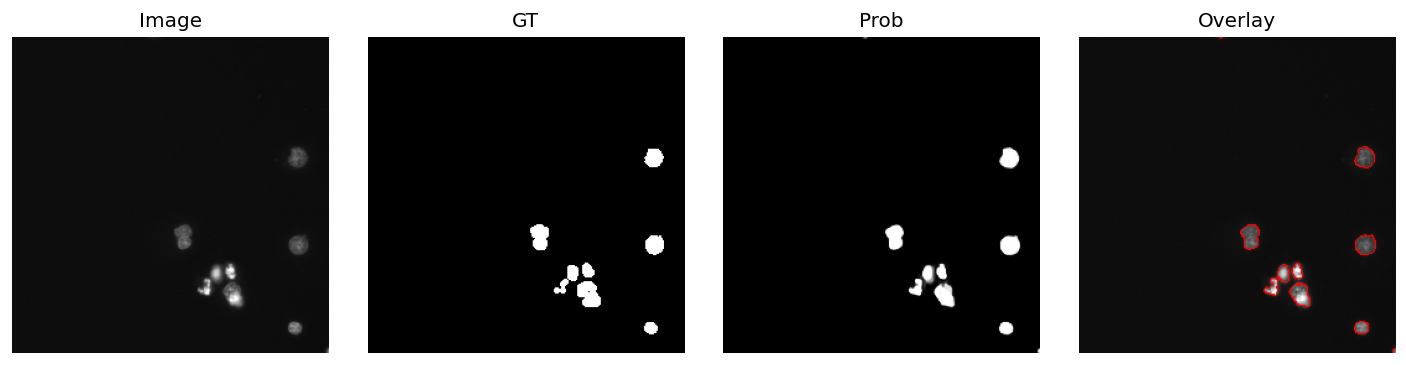

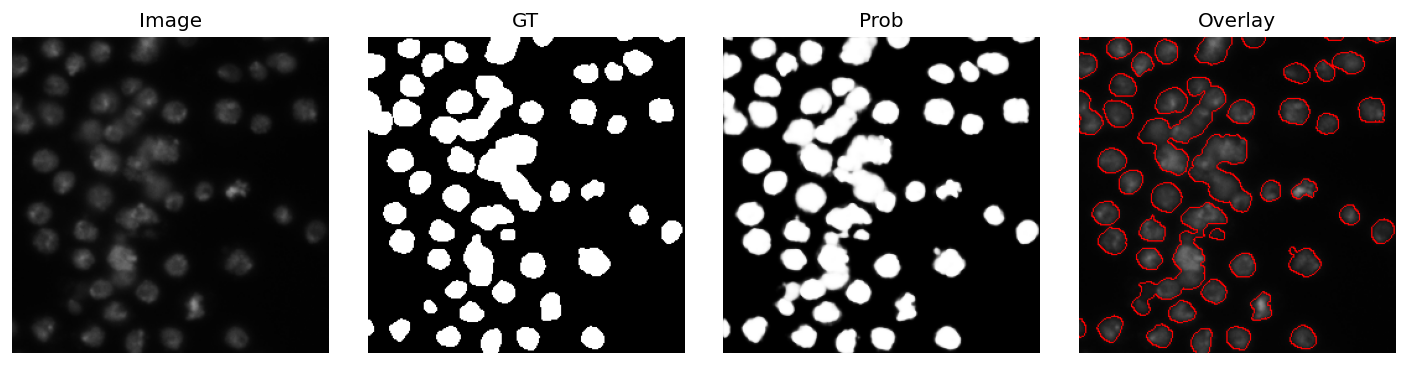

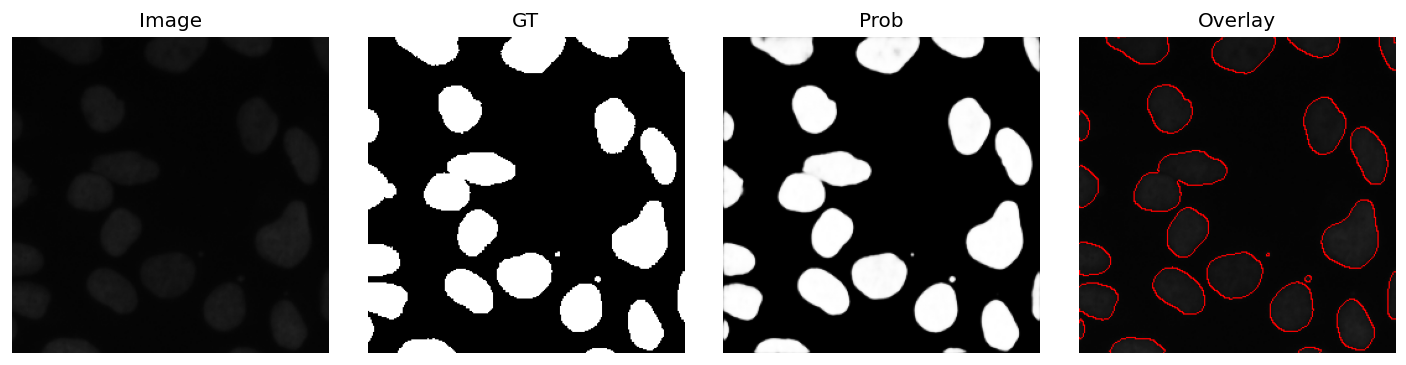

In [27]:
from skimage import measure

def visualize(img, gt, prob, thr=0.5):
    pred = (prob>=thr).astype(np.float32)
    overlay = (img*255).astype(np.uint8).copy()
    # 경계선 표시
    contours = measure.find_contours(pred[...,0], 0.5)
    for c in contours:
        c = np.flip(c, axis=1).astype(np.int32)
        for (x,y) in c:
            if 0<=y<overlay.shape[0] and 0<=x<overlay.shape[1]:
                overlay[y,x] = [255,0,0]

    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1); plt.title('Image');   plt.axis('off'); plt.imshow(img)
    plt.subplot(1,4,2); plt.title('GT');      plt.axis('off'); plt.imshow(gt[...,0], cmap='gray')
    plt.subplot(1,4,3); plt.title('Prob');    plt.axis('off'); plt.imshow(prob[...,0], cmap='gray')
    plt.subplot(1,4,4); plt.title('Overlay'); plt.axis('off'); plt.imshow(overlay)
    plt.tight_layout(); plt.show()

for imgs, masks in val_ds.take(1):
    probs = best.predict(imgs, verbose=0)
    for i in range(min(3, imgs.shape[0])):
        visualize(imgs[i].numpy(), masks[i].numpy(), probs[i], thr=0.5)
